# Assignment: Adversarial Attacks (Adversarial Patches)

# Class: AIPI 590

# Author: Ramil Mammadov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1CB0PMLg3wxSM3OknAEc1xaszn1NHPwn-?usp=sharing)

In [45]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-3344747636.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


#### Here I prepare the notebook for training vision models with PyTorch: I import standard, scientific, and image libraries; configure Matplotlib/Seaborn for inline high-quality plots; and enable tqdm progress bars. I load PyTorch, Torchvision (including CIFAR-10), and PyTorch Lightning (installing it if missing) with helpful callbacks. I set dataset and checkpoint folders, seed everything and enforce deterministic cuDNN for reproducibility, select a GPU if available (otherwise CPU), and print the chosen device.

In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


#### This code downloads the tutorial’s data and model assets from a GitHub URL if they aren’t already present locally. I set the base URL, list two files to fetch (TinyImageNet.zip to DATASET_PATH and patches.zip to CHECKPOINT_PATH), ensure those directories exist, and then, for each file, check whether it’s already there; if not, I download it with urllib, report any HTTP errors, and automatically unzip .zip files into the target directory.

In [3]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 111MB/s]


#### I load a ResNet-34 pretrained on ImageNet, tell PyTorch to use CHECKPOINT_PATH for model files via TORCH_HOME, and move the network to the selected device (GPU if available, else CPU). I switch the model to evaluation mode to use inference behavior (no training updates like BatchNorm stats), and I freeze all parameters (requires_grad = False) so no gradients are computed.

In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### I set ImageNet’s mean and std for normalization, define a simple transform (tensor + normalize), and point to the TinyImageNet folder under DATASET_PATH. I load the dataset with ImageFolder, build a DataLoader (batch size 32, no shuffling), and read label_list.json to map class names to indices. I also add a helper get_label_index that checks the class name exists and returns its numeric label.

In [5]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [7]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


#### I evaluate the pretrained model over a dataloader with a tqdm “Validating…” progress bar. For each batch, I move images/labels to the selected device, optionally apply an img_func to modify the images, and run a forward pass under torch.no_grad() to avoid gradients. I count correct predictions for top-1 (argmax) and top-5 (topk) and keep a running total of samples. At the end, I compute accuracy for both metrics, print the corresponding Top-1 and Top-5 error rates in percent, and return the accuracies.

In [10]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

#### I visualize a model’s prediction for one image. If the input is a tensor, I denormalize it (using ImageNet mean/std), convert to NumPy, and get the integer label. I then plot the original image with its true class, and—optionally—also show an adversarial version plus the perturbation (rescaled to 0–1). I make sure the prediction vector is a proper probability distribution (apply softmax if needed), take the top-K classes, and draw a horizontal bar chart of confidences, highlighting the true class. Finally, I display and close the figure.

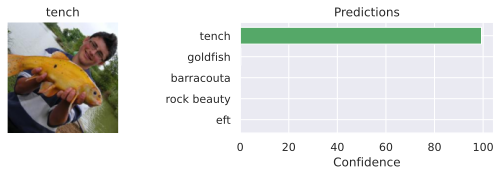

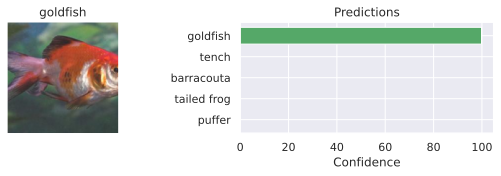

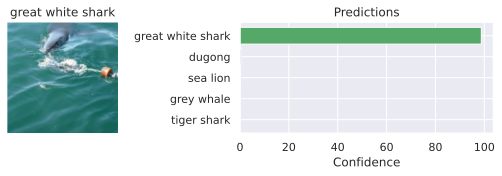

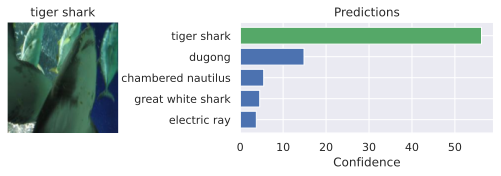

In [11]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

#### I grab one batch from the dataloader, run it through the pretrained model under torch.no_grad() to get predictions, then visualize a few samples (indices 1, 6, 11, 16) with show_prediction. For each sample, I denormalize and display the image with its true label and plot the model’s top-5 predicted classes with confidences, highlighting the true class. The example panels show high-confidence correct predictions (e.g., tench, goldfish, great white shark, tiger shark).

In [12]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

#### I define place_patch to paste a small tensor patch into every image in a batch at a random location. Given img with shape [B, C, H, W] and patch with shape [C, ph, pw], I loop over each item i, sample random height/width offsets that keep the patch inside the image, optionally transform the patch via patch_forward(patch), and overwrite the slice img[i, :, h:h+ph, w:w+pw] with it. The function returns the batch with all images patched.

In [13]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

#### I cache the ImageNet mean and std as 3×1×1 tensors for easy broadcasting. In patch_forward, I take an unconstrained patch tensor, squash it with tanh (to keep values bounded), rescale from [-1, 1] to [0, 1], then convert it into the model’s normalized input space via (x − mean) / std. The function returns this normalized patch, ready to be applied to images.

In [14]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

#### I evaluate a targeted adversarial patch. I switch the model to eval mode and disable gradients, then iterate over the validation loader. For each batch, I paste the patch onto every image at four random locations (to average over placements), run the model, and count how many non-target images get predicted as the target_class (top-1) or include it in their top-5. I exclude images that are already of the target class since those aren’t “fooled.” Finally, I divide the counts by the number of eligible images to get the top-1 and top-5 attack success rates and return them._

In [15]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

#### I train a targeted adversarial patch that makes the model predict a chosen target_class. I split the dataset into 4,500 training and 500 validation images, build loaders, then create a learnable patch tensor of size patch_size and optimize only this parameter with SGD and cross-entropy loss. During training, for each batch I paste the patch at a random location on every image, run the model, set all labels to the target class, compute the loss, and update the patch over several epochs. Afterward, I evaluate on the held-out set with eval_patch, which reports top-1 and top-5 attack success rates (how often non-target images are predicted as the target). I return the trained patch and these metrics.

In [16]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

#### I load any existing evaluation results for pretrained patches from CHECKPOINT_PATH/patch_results.json into json_results (or start with an empty dict if the file doesn’t exist). I also define save_results(patch_dict), which walks the nested results (by class name and patch size), converts any tensors to plain Python numbers with .item(), and writes a neatly indented JSON file back to patch_results.json. This lets me persist and later compare patch metrics across classes and sizes.

In [17]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

#### I loop over each requested class and patch size, get the class index, and build a filename in CHECKPOINT_PATH like {name}_{patch_size}_patch.pt. If that patch file doesn’t exist, I train a targeted adversarial patch with patch_attack (5 epochs), print its validation results, and save it; otherwise, I load the saved patch. For metrics, I first look in json_results; if nothing’s stored yet, I evaluate the patch with eval_patch on the dataloader. I then stash both the metrics ("results") and the patch tensor ("patch") in a nested dictionary result_dict[name][patch_size], and return this dictionary for easy access.

In [37]:
class_names = ['box turtle', 'green lizard', 'green snake', 'sea snake', 'scorpion']
patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for box turtle and 64: {'acc': 0.9739999771118164, 'top5': 0.9994999766349792}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for green lizard and 64: {'acc': 0.9869999885559082, 'top5': 0.9994999766349792}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for green snake and 64: {'acc': 0.9799599051475525, 'top5': 0.9989979863166809}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for sea snake and 64: {'acc': 0.9604208469390869, 'top5': 0.9959920048713684}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for scorpion and 64: {'acc': 0.9944999814033508, 'top5': 1.0}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

#### I set the target classes and patch size(s), then call get_patches to load or train a 64×64 adversarial patch for each class and evaluate it. The function returns patch_dict containing each patch and its metrics, and I can persist those with save_results if needed. The printed lines show the attack success rates on the hold-out split—acc is top-1 success (how often images are flipped to the target class), and top5 is top-5 success—for each class at patch size 64.

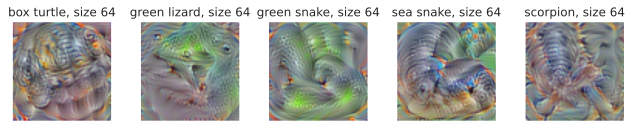

In [46]:
def show_patches():
    nrows, ncols = len(patch_sizes), len(class_names)
    fig, ax = plt.subplots(nrows, ncols, squeeze=False,
                           figsize=(ncols*2.2, nrows*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2
            patch = patch.detach().cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, 0.0, 1.0)
            ax[p_idx, c_idx].imshow(patch)
            ax[p_idx, c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx, c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

#### I define show_patches to visualize the learned adversarial patches for every class and patch size. It creates a grid with rows = patch sizes and columns = class names, pulls each patch from patch_dict, squashes it with tanh and rescales to [0,1], converts the tensor to an H×W×C NumPy image, clips values, and displays it in the corresponding subplot with the title "{class}, size {psize}". Axes are hidden, spacing is adjusted for readability, and the function is called to render the gallery.

Saved: /saved_models/box turtle_size64.png
Saved: /saved_models/green lizard_size64.png
Saved: /saved_models/green snake_size64.png
Saved: /saved_models/sea snake_size64.png
Saved: /saved_models/scorpion_size64.png


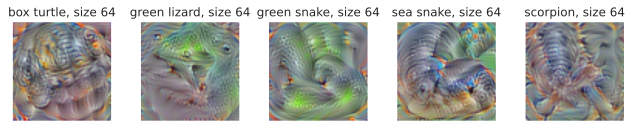

In [49]:
def save_patches(output_dir="/saved_models", display_size=224):
    """
    Saves every patch as an RGB square image (display_size x display_size),
    so they align nicely in Streamlit grids.
    """
    os.makedirs(output_dir, exist_ok=True)

    for cname in class_names:
        for psize in patch_sizes:
            patch = patch_dict[cname][psize]["patch"]              # [C,H,W] torch
            patch = (torch.tanh(patch) + 1) / 2                    # [0,1]
            patch = patch.detach().cpu().permute(1, 2, 0).numpy()  # HWC
            patch = np.clip(patch, 0.0, 1.0)

            # to PIL (RGB), scale to 0-255, fix size to display_size x display_size
            pil = Image.fromarray((patch * 255).astype(np.uint8)).convert("RGB")
            pil = pil.resize((display_size, display_size), Image.BICUBIC)

            save_path = os.path.join(output_dir, f"{cname}_size{psize}.png")
            pil.save(save_path, format="PNG", optimize=True)
            print(f"Saved: {save_path}")



save_patches()

show_patches()

#### I save each learned adversarial patch as a tidy RGB PNG for display. For every class and patch size, I take the patch tensor, squash it with tanh and rescale to [0,1], move it to CPU, convert to H×W×C, clip, and turn it into a PIL image. I then resize it to a square display_size (default 224) with bicubic resampling and write it to output_dir (default /saved_models) as {class}_size{psize}.png. Finally, I call save_patches() to export the images and show_patches() to render the gallery.

In [50]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [51]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [52]:
show_table(top_1=True)

Class name,Patch size 64x64
box turtle,97.68%
green lizard,98.67%
green snake,98.49%
sea snake,95.90%
scorpion,99.40%


In [53]:
show_table(top_1=False)

Class name,Patch size 64x64
box turtle,99.86%
green lizard,99.95%
green snake,99.93%
sea snake,99.76%
scorpion,100.00%


#### I first bump the table font size with a small HTML/CSS snippet so results are easier to read. Then I define show_table(top_1=True): it picks which metric to show (index 0 = top-1, 1 = top-5), builds a row per class with the corresponding percentage for each patch size, and renders a clean HTML table using tabulate with headers like “Class name” and “Patch size 64×64.” I call show_table(top_1=True) for top-1 success and show_table(top_1=False) for top-5.

In [81]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(6,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

#### I clone the example batch to keep the originals intact, paste the given patch onto every image at a random location, and run the patched batch through the pretrained model on the selected device with gradients disabled. Then I visualize a few patched samples (indices 6, 11, and 16) using show_prediction, which displays the image and a top-K confidence bar chart for the model’s predictions._

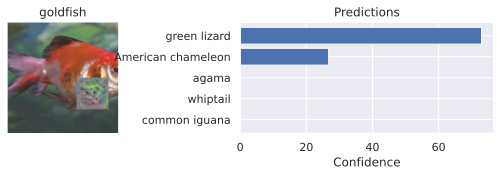

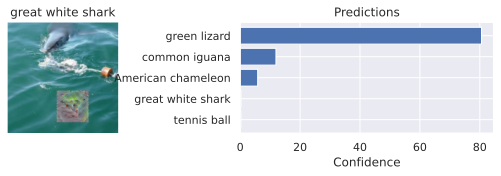

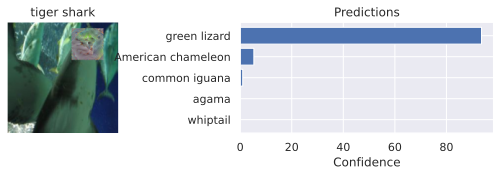

In [80]:
perform_patch_attack(patch_dict['green lizard'][64]['patch'])

#### I apply the 64×64 green lizard adversarial patch to a few images in the batch, run the patched images through the model, and plot the top-5 predictions. In these examples (goldfish, great white shark, tiger shark), the patch reliably flips the model to predict green lizard with high confidence, pushing the true class down the list—showing a successful targeted patch attack.

### Background:
Volunteers put trail cameras out to find and protect green lizards. Some fans add lizard stickers near the lenses to “help.” The computer mistakes the stickers for real animals, so the counts shoot up. Maps now say lizards are everywhere, and teams go to the wrong places. Time and money get wasted, people stop trusting the numbers, and real lizards are missed. A small trick makes the work look successful when it isn’t.
### What was the reason to put them near the cameras?
Some fans cared a lot about green lizards and were scared the cameras weren’t finding enough. They’d heard funding depends on “numbers,” so they thought more sightings would bring more money and faster protection. An app even gave badges for reports, which made it feel like a game. A rumor spread that “showing the camera a few lizards” would help it learn. A local group also worried a new road would be approved unless the map showed many lizards nearby. None of them meant harm—they just believed more dots on the map would save the lizards—so they stuck fake lizards near the lenses, not seeing how it would backfire.


## Note:
ChatGPT 5 was used to assist with parts of the coding and markdown formatting in this assignment.